# Linear Frequency-Dependent PTO 

In [1]:
import os
import logging

import matplotlib.pyplot as plt
import capytaine as cpy
from autograd.builtins import isinstance, tuple, list, dict
import autograd.numpy as np
import xarray as xr

import wecopttool as wot


# logging 
logging.basicConfig(level=logging.INFO)

# create save directory
results_dir = 'results_linear_freqdep_pto'
if not os.path.exists(results_dir):
  os.makedirs(results_dir)

# frequencies
f0 = 0.05
nfreq = 50

### WEC

In [2]:
## WEC object
# mesh
wb = wot.geom.WaveBot() 
mesh_size_factor = 0.5 
mesh = wb.mesh(mesh_size_factor)

# floating body
fb = cpy.FloatingBody.from_meshio(mesh, name="WaveBot")
fb.add_translation_dof(name="HEAVE")

# hydrostatics
hs_data = wot.hydrostatics.hydrostatics(fb)
mass_33 = wot.hydrostatics.mass_matrix_constant_density(hs_data)[2, 2]
mass = np.atleast_2d(mass_33)
stiffness_33 = wot.hydrostatics.stiffness_matrix(hs_data)[2, 2]
stiffness = np.atleast_2d(stiffness_33)

# WEC object
wec = wot.WEC(fb, mass, stiffness, f0, nfreq)

# BEM
fname = os.path.join(results_dir, 'bem.nc')
if os.path.exists(fname):
    wec.read_bem(fname)
else:
    wec.run_bem()
    wec.write_bem(fname)

INFO:capytaine.bodies.bodies:Stored 1054 triangle faces as quadrilaterals
INFO:capytaine.bodies.bodies:New floating body: WaveBot.
INFO:wecopttool.core:Changing value of 'f_add'. This might cause some attributes to be reset.
INFO:wecopttool.core:New WEC: WaveBot with 1 DOF.
INFO:wecopttool.core:Reading BEM data from results_linear_freqdep_pto/bem.nc.
INFO:wecopttool.core:Impedance matrix deleted. To calculate impedance call 'self.bem_calc_impedance()'
INFO:wecopttool.core:Impedance matrix deleted. To calculate impedance call 'self.bem_calc_impedance()'
INFO:wecopttool.core:Calculating impedance matrix.
INFO:capytaine.post_pro.impedance:Compute impedance.


### PTO

In [3]:
# PTO kinematics
kinematics = np.eye(fb.nb_dofs)

# PTO impedance - frequency dependent
gear_ratio = 12.0
torque_constant = 6.7
winding_resistance = 0.5
winding_inductance = 0.0
drivetrain_inertia = 2.0 
drivetrain_friction = 1.0
drivetrain_stiffness = 0.0

drivetrain_impedance = (1j*wec.omega*drivetrain_inertia + 
                        drivetrain_friction + 
                        -1/(1j*wec.omega)*drivetrain_stiffness) 

winding_impedance = winding_resistance + 1j*wec.omega*winding_inductance

pto_impedance_11 = gear_ratio**2 * drivetrain_impedance
off_diag = np.sqrt(3.0/2.0) * torque_constant * gear_ratio
pto_impedance_12 = (off_diag+0j) * np.ones(wec.omega.shape) 
pto_impedance_21 = pto_impedance_12
pto_impedance_22 = winding_impedance
pto_impedance = np.array([[pto_impedance_11, pto_impedance_12],
                          [pto_impedance_21, pto_impedance_22]])

# create PTO
pto = wot.pto.ProportionalIntegralLinearPTO(nfreq, kinematics, pto_impedance)
# pto = wot.pto.PseudoSpectralLinearPTO(nfreq, kinematics, pto_impedance)

# add PTO force to WEC
wec.f_add = pto.force_on_wec


INFO:wecopttool.core:Changing value of 'f_add'. This might cause some attributes to be reset.


### Waves

In [4]:
# waves
wfreq = 0.3
amplitude = 0.0625
phase = -40
waves = wot.waves.regular_wave(f0, nfreq, wfreq, amplitude, phase)

# waves
# fp = 1.0/2.0  # Hz
# hs = 0.2  # m
# gamma = 3.3
# spectrum_func = lambda freq: wot.waves.jonswap_spectrum(freq, fp, hs, gamma)
# spectrum_name = "JONSWAP"
# direction = 0.0
# waves = wot.waves.long_crested_wave(
#     f0, nfreq, spectrum_func, direction, spectrum_name)

### Objective Function

In [5]:
# objective function
obj_fun = pto.electric_average_power
nstate_opt = pto.nstate

### Solve

In [6]:
# solve
scale_x_wec = 1.0
scale_x_opt = 0.001
scale_obj = 1.0

options = {'maxiter': 100, 'ftol': 1e-8}

wec_tdom, wec_fdom, x_wec, x_opt, obj, res = wec.solve(
    waves, obj_fun, nstate_opt, optim_options=options,
    scale_x_wec=scale_x_wec, scale_x_opt=scale_x_opt, scale_obj=scale_obj)

# post-process
pto_tdom, pto_fdom = pto.post_process(wec, x_wec, x_opt)

INFO:wecopttool.core:Solving pseudo-spectral control problem.
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [2.19e+04, 3.35e+05, 5.11e+26]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [1.28e+03, 2.10e+05, 1.57e+23]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [5.57e+02, 3.28e+05, 6.40e+24]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [4.08e-01, 1.95e+01, 2.04e+07]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [2.59e-02, 2.93e+00, 1.49e+05]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [2.01e-03, 3.74e+00, 4.89e+02]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [5.71e-04, 3.75e+00, 1.45e+01]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [5.73e-04, 3.75e+00, 1.45e+01]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [5.73e-04, 3.75e+00, 1.45e+01]
INFO:wecopttool.core:[mean(x_wec), mean(x_opt), obj_fun(x)]: [5.73e-04, 3.75e+00, 1.45e+01]
INFO:wecopttool.co

Optimization terminated successfully    (Exit mode 0)
            Current function value: -25.58724889746474
            Iterations: 54
            Function evaluations: 89
            Gradient evaluations: 54


### CC (Electrical) Solution


In [7]:
Z_11 = pto_impedance[0, 0, :]
Z_12 = pto_impedance[0, 1, :]
Z_21 = pto_impedance[1, 0, :]
Z_22 = pto_impedance[1, 1, :]

idof = 0
Fe = wec_fdom['excitation_force'][1:, idof]
Zi = wec.hydro.Zi[:, idof, idof]

V_th = Z_21 / (Z_11 - Zi) * Fe
Z_th = Z_22 - (Z_12*Z_21) / (Z_11 - Zi)

cc_current_fd = V_th / (2*Z_th.real)
cc_voltage_fd = -1.0 * Z_th.conj() * cc_current_fd

cc_current_td = wot.post_process_continuous_time(cc_current_fd)
cc_voltage_td = wot.post_process_continuous_time(cc_voltage_fd)

In [8]:
# Mechanical quantities
cc_velocity_fd = np.zeros(nfreq) *0j
cc_force_fd = np.zeros(nfreq) * 0j

for ifreq in range(nfreq):
    abcd_inv = np.linalg.inv(pto._impedance_abcd[:, :, ifreq])
    vec_elec = np.array([[cc_current_fd[ifreq]], [cc_voltage_fd[ifreq]]])
    vec_mech = abcd_inv @ vec_elec
    cc_velocity_fd[ifreq] = vec_mech[0, 0]
    cc_force_fd[ifreq] = vec_mech[1, 0]

cc_velocity_fd = xr.DataArray(
    cc_velocity_fd, dims=["omega"], coords=[("omega", wec.omega),],)
cc_force_fd = xr.DataArray(
    cc_force_fd, dims=["omega"], coords=[("omega", wec.omega), ],)

cc_velocity_td = wot.post_process_continuous_time(cc_velocity_fd)
cc_force_td = wot.post_process_continuous_time(cc_force_fd)

### Compare Results to CC

Text(0, 0.5, 'electrical power [W]')

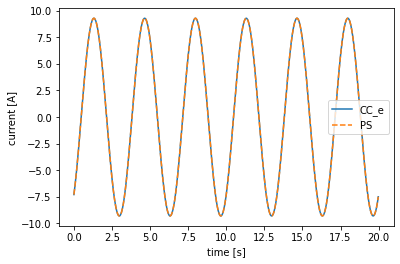

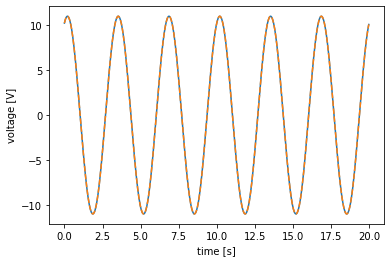

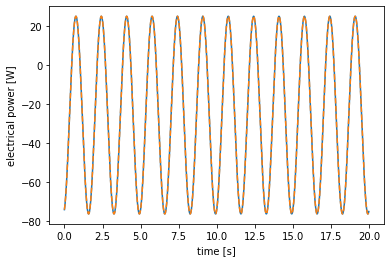

In [9]:
nsubsteps = 10
t = wec.make_time_vec(nsubsteps)

# plot electrical power
plt.figure()
plt.plot(t, cc_current_td(t), '-', label='CC_e')
plt.plot(t, pto.electric_current(
    wec, x_wec, x_opt, nsubsteps), '--', label='PS')
plt.xlabel('time [s]')
plt.ylabel('current [A]')
plt.legend()

plt.figure()
plt.plot(t, cc_voltage_td(t), '-')
plt.plot(t, pto.electric_voltage(wec, x_wec, x_opt, nsubsteps), '--')
plt.xlabel('time [s]')
plt.ylabel('voltage [V]')

plt.figure()
plt.plot(t, cc_current_td(t)*cc_voltage_td(t), '-')
plt.plot(t, pto.electric_power(wec, x_wec, x_opt, nsubsteps), '--')
plt.xlabel('time [s]')
plt.ylabel('electrical power [W]')

Text(0, 0.5, 'mechanical power [W]')

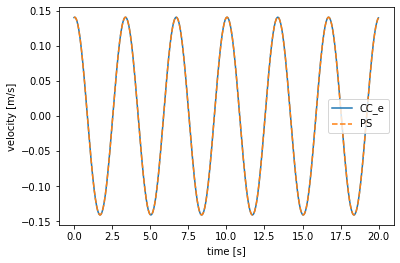

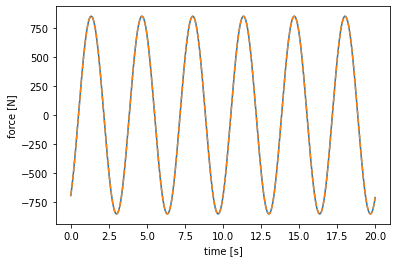

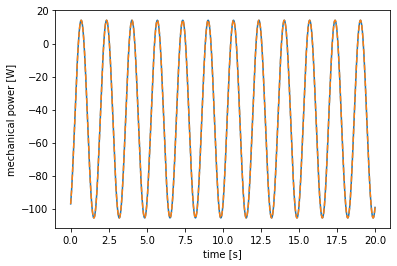

In [10]:
# plot mechanical power
plt.figure()
plt.plot(t, cc_velocity_td(t), '-', label='CC_e')
plt.plot(t, pto.velocity(
    wec, x_wec, x_opt, nsubsteps), '--', label='PS')
plt.xlabel('time [s]')
plt.ylabel('velocity [m/s]')
plt.legend()

plt.figure()
plt.plot(t, cc_force_td(t), '-')
plt.plot(t, pto.force(wec, x_wec, x_opt, nsubsteps), '--')
plt.xlabel('time [s]')
plt.ylabel('force [N]')

plt.figure()
plt.plot(t, cc_velocity_td(t)*cc_force_td(t), '-')
plt.plot(t, pto.power(wec, x_wec, x_opt, nsubsteps), '--')
plt.xlabel('time [s]')
plt.ylabel('mechanical power [W]')

### PI Theoretical gains

In [11]:
x_opt

array([ 7318.13531754, -4605.65762685])

In [12]:
ind = int(np.where(np.isclose(wec.freq, wfreq))[0])
tmp = cc_force_fd / cc_velocity_fd
tmp = tmp.values[ind]
(-np.imag(tmp)*wec.omega[ind], np.real(tmp))

(7318.135330821697, -4605.65764773741)